# **🥖 French Bakery Sales Analysis and Forecasting 🥖**

Hello and welcome ✋. In this notebook, you will see the work that aiming:
* Explore the data 🔍
* Visualize the relations 📊
* Data mining to obtain associative rules ⛏
* Predictive modeling with deep learning algorithm LSTM 🧠
* Visualize the prediction results 📈

Let's dive in ⚡

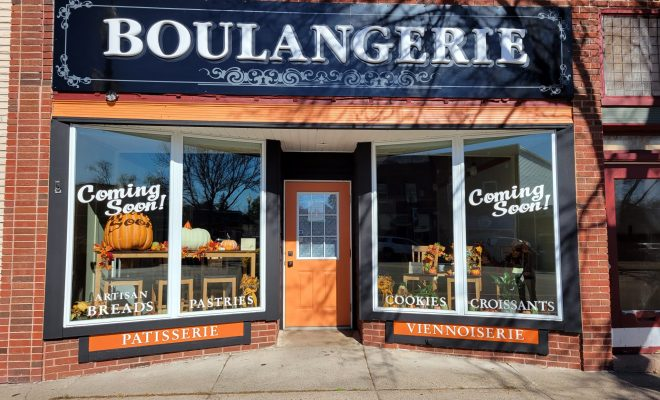

image from : https://tomahawkleader.com/2022/02/01/traditional-french-bakery-boulangerie-to-host-grand-opening-in-downtown-tomahawk/

french-bread-bakery-product-set-colored-vector-illustration-tabatiere-epi-baguette-bagel-slices-breads-bake-roll-pastry-pain-au-levain-petits-pains-ets_202271-2073.png

image from: https://www.freepik.com/premium-vector/french-bread-bakery-product-set-colored-vector-illustration-tabatiere-epi-baguette-bagel-slices-breads-bake-roll-pastry-pain-au-levain-petits-pains-ets_20226839.htm

### About the data:

* The dataset belongs to a French bakery.
* The dataset provides the daily transaction details of customers from 2021-01-01 to 2022-09-30.
* The dataset has 234005 entries, over 136000 transactions and 6 columns.
* Variables are:
  * date: date order
  * time: time order
  * ticket number: identifier for every single transaction
  * article: name of the product sold (in French)
  * quantity: quantity sold
  * unit_price: price per product

info has taken from: https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales

## Data Exploration

Importing necessary libraries for analyse the data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
from datetime import datetime, timedelta

First look

In [ ]:
bakery = pd.read_csv("Bakery sales.csv").iloc[:, -6:]
bakery.head()

,date,time,ticket_number,article,Quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


Examining the type of variables and the presence of null values

In [ ]:
bakery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  object 
dtypes: float64(2), object(4)
memory usage: 10.7+ MB


* Date variable must be the datetime type of variable.
* unit_price should be an integer
* Revenue variable will tell us the income of the transaction

In [ ]:
bakery["date"] = pd.to_datetime(bakery["date"])
bakery["unit_price"] = bakery["unit_price"].apply(lambda x : round(float(x[:-2].replace(",",".")),2))
bakery = bakery.assign(Revenue = bakery["Quantity"] * bakery["unit_price"]).rename(columns={"Revenue":"Revenue (€)"})
bakery.head()

,date,time,ticket_number,article,Quantity,unit_price,Revenue (€)
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20,3.60
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2.40
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,6.00


Statistical look to the numerics

In [ ]:
bakery.describe().T

,count,mean,std,min,25%,50%,75%,max
ticket_number,234005.0,219201.258738,40053.223896,150040.0,184754.0,218807.0,253927.0,288913.0
Quantity,234005.0,1.538377,1.289603,-200.0,1.0,1.0,2.0,200.0
unit_price,234005.0,1.662195,1.722720,0.0,1.1,1.2,1.5,60.0
Revenue (€),234005.0,2.387303,2.635041,-200.0,1.2,1.6,2.6,200.0


There are some negative quantity values in the Quantity column. They should be removed  

In [ ]:
bakery = bakery[~(bakery["Quantity"] < 0)]

Horizontal bar plot to visualize the most popular items

Text(0.5, 0, 'Number of bought')

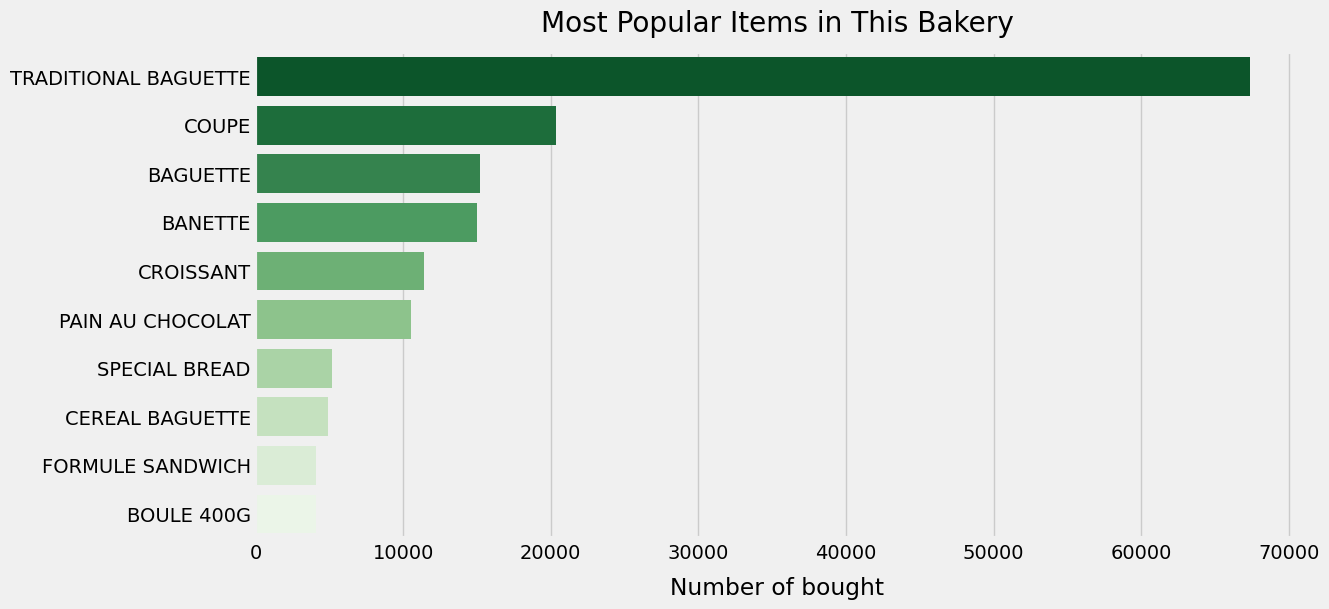

In [ ]:
val_counts = dict(bakery["article"].value_counts()[:10])
plt.figure(figsize=(12,6))
sns.barplot(y=list(val_counts.keys()), x=list(val_counts.values()), palette="Greens_r")
plt.title("Most Popular Items in This Bakery", pad=15)
plt.xlabel("Number of bought", labelpad=10)

DayPart variable will be added to the dataframe

In [ ]:
def set_daypart(hour):
  if hour < "12:00":
    return "Morning"
  elif hour >= "12:00" and hour < "17:00":
    return "Afternoon"
  else:
    return "Evening"

bakery["DayPart"] = bakery["time"].apply(lambda x : set_daypart(x))
daypart = dict(bakery.groupby('DayPart')['article'].count().sort_values(ascending=False))

Pie chart that shows the percentage of transactions in each part of the day

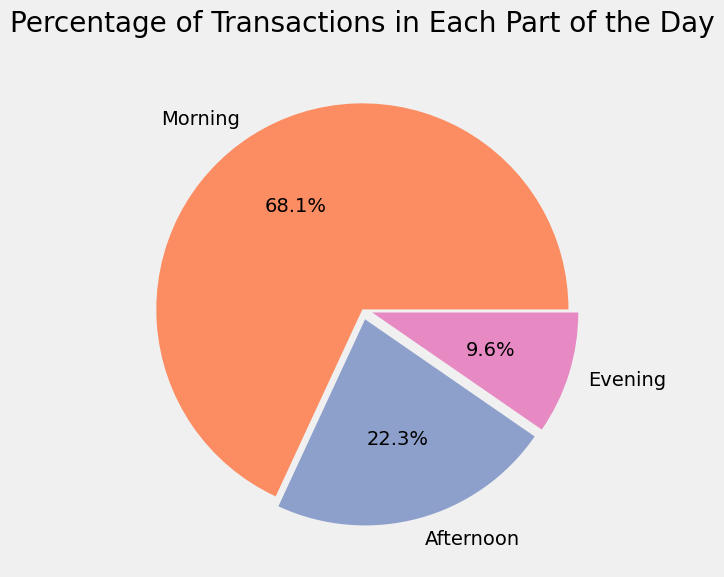

In [ ]:
plt.figure(figsize=(12,6))
plt.pie(daypart.values(), labels=daypart.keys(), explode=[0, 0.05, 0.05], colors = sns.color_palette("Set2")[1:], autopct='%.1f%%')
plt.title("Percentage of Transactions in Each Part of the Day", pad=15)
plt.tight_layout()
plt.show()

At this step, it would be useful if we group the transactions by date and items.

In [ ]:
daily_sales = bakery.groupby(["date", "article"]).agg({"Quantity":"sum", "unit_price":"mean"})
daily_sales = daily_sales.assign(Revenue = daily_sales["Quantity"] * daily_sales["unit_price"]).rename(columns={"Revenue":"Revenue (€)"})
daily_sales.head()

Quantity  unit_price  Revenue (€)
date       article                                      
2021-01-02 BAGUETTE        46.0        0.90         41.4
           BANETTE         40.0        1.05         42.0
           BANETTINE        6.0        0.60          3.6
           BOULE 200G       6.0        1.10          6.6
           BOULE 400G      11.0        1.50         16.5

We can examine each item with their revenues. Also, we can sum them up.

In [ ]:
daily_revenue = daily_sales.groupby("date")["Revenue (€)"].sum().reset_index()
daily_revenue.head()

,date,Revenue (€)
0,2021-01-02,987.85
1,2021-01-03,1015.20
2,2021-01-04,461.90
3,2021-01-05,526.10
4,2021-01-07,544.00


Time dependent features would be added as a seperate column

In [ ]:
def get_time_features(baguette):

  baguette['month'] = baguette.date.dt.month.astype("int8")
  baguette['month_name'] = baguette.date.dt.month_name()
  baguette['day_of_month'] = baguette.date.dt.day.astype("int8")
  baguette['week_of_year'] = (baguette.date.dt.weekofyear).astype("int8")

  # 0: Winter - 1: Spring - 2: Summer - 3: Fall
  baguette["season"] = np.where(baguette.month.isin([12,1,2]), "Winter",  "Spring")
  baguette["season"] = np.where(baguette.month.isin([6,7,8]), "Summer", baguette["season"])
  baguette["season"] = np.where(baguette.month.isin([9, 10, 11]), "Fall", baguette["season"])

  baguette['weekday_name'] = baguette.date.dt.day_name()
  baguette["quarter"] = baguette.date.dt.quarter.astype("int8")

  return baguette

By calling the function, we obtained the values like month, season, weekday etc.

In [ ]:
bakery_with_time = get_time_features(daily_revenue)

<ipython-input-12-89bf694bbab1>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  baguette['week_of_year'] = (baguette.date.dt.weekofyear).astype("int8")


Grouping the variables to get better insigths

In [ ]:
def group_cols(col):
  return dict(sorted(dict(bakery_with_time.groupby(col)["Revenue (€)"].mean()).items(), key=lambda x:x[1], reverse=True))

We will visualize them in the next part

In [ ]:
rev_by_month = group_cols("month_name")
rev_by_dayofmonth = group_cols("day_of_month")
rev_by_weekofyear = group_cols("week_of_year")
rev_by_season = group_cols("season")
rev_by_weekday = group_cols("weekday_name")
rev_by_seaason_and_weekday = group_cols(["season", "weekday_name"])
rev_by_quarter = group_cols("quarter")

## Visualization

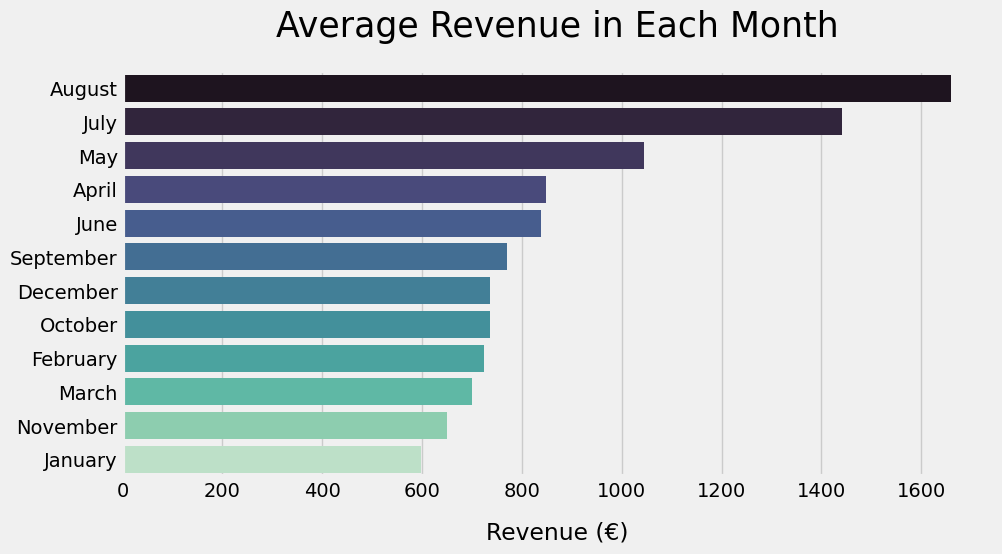

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(y=list(rev_by_month.keys()), x=list(rev_by_month.values()), palette="mako")
plt.title("Average Revenue in Each Month", pad=25, fontsize=25)
plt.xlabel("Revenue (€)", labelpad=15)
plt.show()

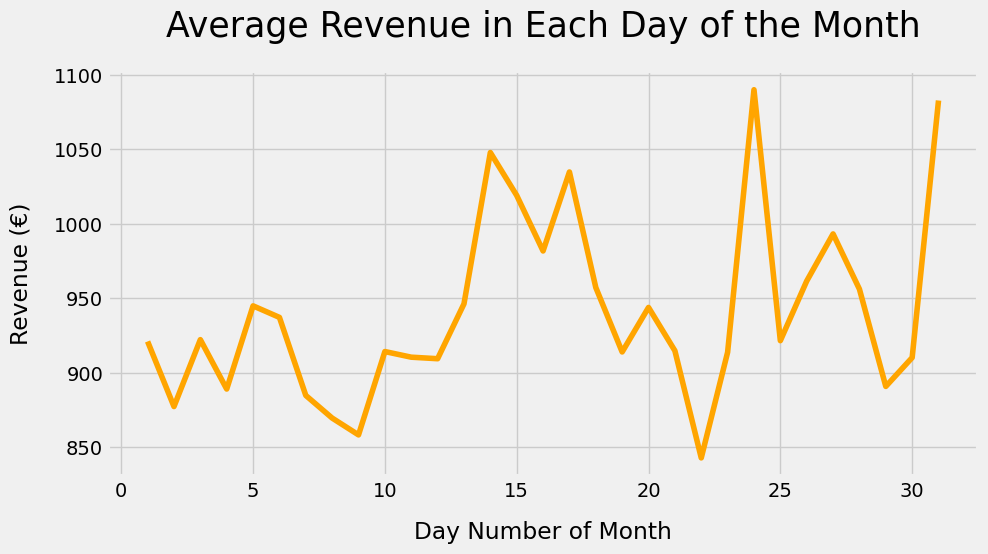

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x=list(rev_by_dayofmonth.keys()), y=list(rev_by_dayofmonth.values()), color="orange")
plt.title("Average Revenue in Each Day of the Month", pad=25, fontsize=25)
plt.xlabel("Day Number of Month", labelpad=15)
plt.ylabel("Revenue (€)", labelpad=15)
plt.show()

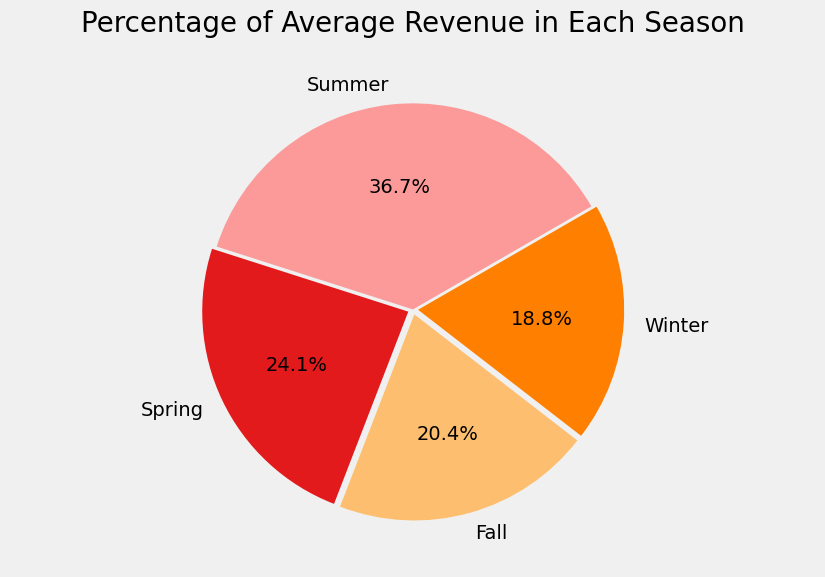

In [ ]:
plt.figure(figsize=(12,6))
plt.pie(rev_by_season.values(), labels=rev_by_season.keys(), explode=[0, 0.025, 0.025, 0.025], colors = sns.color_palette("Paired")[4:9], autopct='%.1f%%', startangle=30)
plt.title("        Percentage of Average Revenue in Each Season        ", pad=15, fontsize=20)
plt.tight_layout()
plt.show()

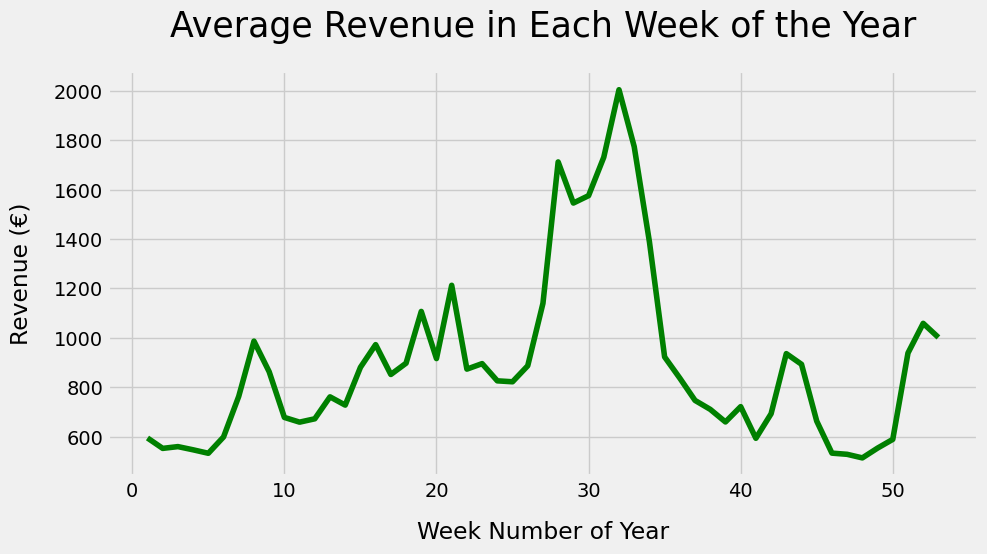

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x=list(rev_by_weekofyear.keys()), y=list(rev_by_weekofyear.values()), color="green")
plt.title("Average Revenue in Each Week of the Year", pad=25, fontsize=25)
plt.xlabel("Week Number of Year", labelpad=15)
plt.ylabel("Revenue (€)", labelpad=15)
plt.show()

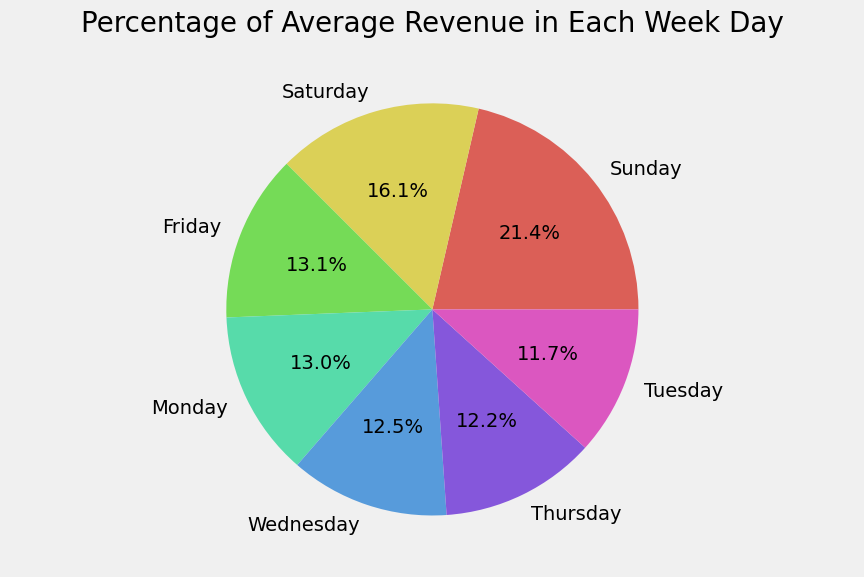

In [ ]:
plt.figure(figsize=(12,6))
plt.pie(rev_by_weekday.values(), labels=rev_by_weekday.keys(), colors = sns.color_palette("hls", 7), autopct='%.1f%%')
plt.title("        Percentage of Average Revenue in Each Week Day        ", pad=15, fontsize=20)
plt.tight_layout()
plt.show()

To get rid of groupby effect, we deployed temporary data frame to visualize with two groupby parameters

In [ ]:
temp = pd.DataFrame.from_dict(rev_by_seaason_and_weekday, orient="index", columns=["Revenue (€)"]).reset_index()
seasons, weekdays = [], []

for i in range(len(temp)):
  seasons.append(list(temp["index"][i])[0])
  weekdays.append(list(temp["index"][i])[1])

temp["Seasons"] = seasons
temp["Week Days"] = weekdays

temp.head()

,index,Revenue (€),Seasons,Week Days
0,"(Summer, Sunday)",1951.730037,Summer,Sunday
1,"(Summer, Saturday)",1500.766154,Summer,Saturday
2,"(Spring, Sunday)",1366.457198,Spring,Sunday
3,"(Summer, Monday)",1283.318269,Summer,Monday
4,"(Summer, Thursday)",1167.693803,Summer,Thursday


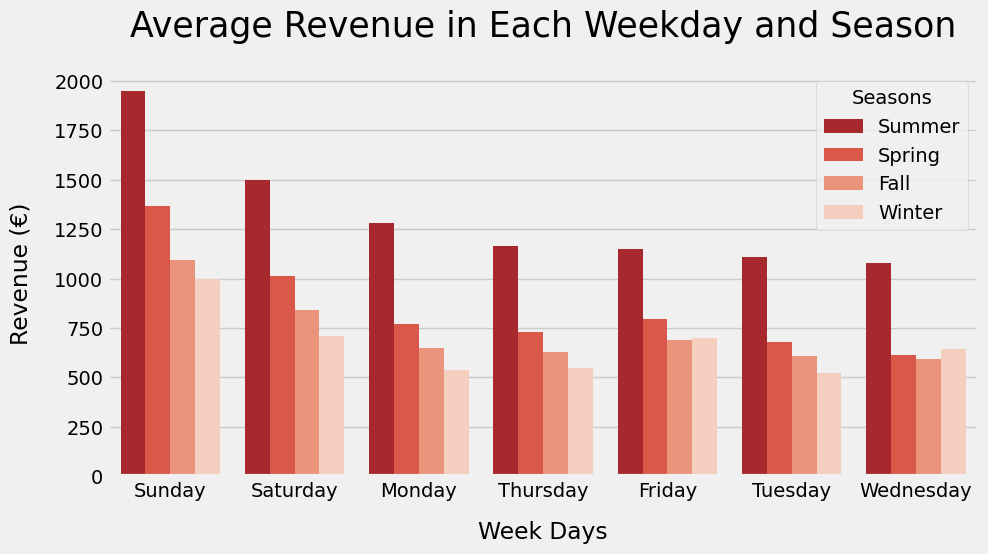

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=temp["Week Days"], y=temp["Revenue (€)"], hue=temp["Seasons"], palette="Reds_r")
plt.title("Average Revenue in Each Weekday and Season", pad=25, fontsize=25)
plt.xlabel("Week Days", labelpad=15)
plt.ylabel("Revenue (€)", labelpad=15)
plt.show()

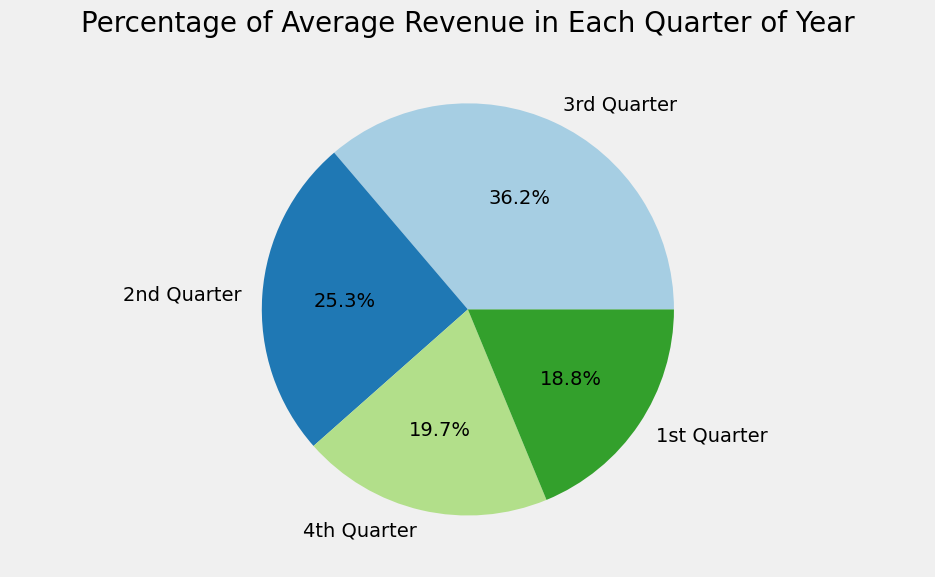

In [ ]:
plt.figure(figsize=(12,6))
plt.pie(rev_by_quarter.values(), labels=["3rd Quarter", "2nd Quarter", "4th Quarter", "1st Quarter"], colors = sns.color_palette("Paired"), autopct='%.1f%%')
plt.title("        Percentage of Average Revenue in Each Quarter of Year        ", pad=15, fontsize=20)
plt.tight_layout()
plt.show()

## Association Rule Mining

* In this section, we will analyze the frequent patterns of bought items.
* This means, we will detect which items are bought together more frequently
* For this purpose, we will use the Apriori algorithm.

The items bought only once can not be included in any frequent itemset.

In [ ]:
val_counts = bakery["article"].value_counts()
val_counts.tail(15)

GD PLATEAU SALE             2
FORMULE PATE                2
TARTELETTE COCKTAIL         1
PLAQUE TARTE 25P            1
ARTICLE 295                 1
CAKE                        1
TROIS CHOCOLAT              1
PLAT 6.50E                  1
PLATPREPARE6,00             1
CRUMBLECARAMEL OU PISTAE    1
REDUCTION SUCREES 24        1
PAIN NOIR                   1
BUCHE 8PERS                 1
DOUCEUR D HIVER             1
SACHET DE VIENNOISERIE      1
Name: article, dtype: int64

We will detect and delete them

In [ ]:
single = list(val_counts.tail(13).index)

In [ ]:
bakery["article"] = bakery["article"].apply(lambda x:"-" if x in single else x)

Concatenate the items bought in the same transaction.

In [ ]:
def concat_items(x):
  l = []
  l.append(x)
  return np.ravel(l)

To do this, we will utilize from ticket_number

In [ ]:
basket_df = bakery.groupby(["ticket_number"])["article"].agg(concat_items).reset_index()

This new data is named "basket" indicates the market basket

In [ ]:
basket_df.head()

,ticket_number,article
0,150040.0,"[BAGUETTE, PAIN AU CHOCOLAT]"
1,150041.0,"[PAIN AU CHOCOLAT, PAIN]"
2,150042.0,[TRADITIONAL BAGUETTE]
3,150043.0,"[BAGUETTE, CROISSANT]"
4,150044.0,[BANETTE]


Convert them from array to list

In [ ]:
items = []
for i in basket_df["article"]:
  items.append(i.tolist())

TransactionEncoder will deploy a matrix that fills true if corresponding item is bought in specified transaction index based on basket_df

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(items).transform(items)
freq_df = pd.DataFrame(te_ary, columns=te.columns_).iloc[:,2:]
freq_df

,12 MACARON,ARMORICAIN,BAGUETTE,BAGUETTE APERO,BAGUETTE GRAINE,BANETTE,BANETTINE,BOISSON 33CL,BOTTEREAU,BOULE 200G,...,TARTELETTE FRAISE,THE,TRADITIONAL BAGUETTE,TRAITEUR,TRIANGLES,TROPEZIENNE,TROPEZIENNE FRAMBOISE,TULIPE,VIENNOISE,VIK BREAD
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135681,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135682,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
135683,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
135684,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


Apriori algorithm will calculate the support values for each item and possible itemsets.

In [ ]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(freq_df, min_support=0.001, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets["support"] = frequent_itemsets["support"].apply(lambda x: round(x*100, 2))
all_freq = frequent_itemsets.sort_values(by="support", ascending=False).reset_index().drop("index", axis=1)
all_freq.head()

,support,itemsets,length
0,49.52,(TRADITIONAL BAGUETTE),1
1,14.26,(COUPE),1
2,11.21,(BAGUETTE),1
3,11.05,(BANETTE),1
4,8.39,(CROISSANT),1


Support value indicates the frequency of item in transactions. For example, Baguette has bought 11.21% of the transactions.

In [ ]:
freq_len_2 = frequent_itemsets[(frequent_itemsets['length'] == 2)].sort_values(by="support", ascending=False).reset_index().drop("index", axis=1)
freq_len_2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,length
0,4.49,"(TRADITIONAL BAGUETTE, COUPE)",2
1,3.96,"(PAIN AU CHOCOLAT, CROISSANT)",2
2,3.61,"(TRADITIONAL BAGUETTE, CROISSANT)",2
3,3.09,"(TRADITIONAL BAGUETTE, PAIN AU CHOCOLAT)",2
4,2.38,"(BOULE 400G, COUPE)",2


We can examine the itemset of 2 items seperately

Confidence score will tell us that when x item is bought, there is % of chance that y will also bought, and vice versa

In [ ]:
def confidence_on_items(x, y, min_conf=0):
    x1 = [t for t in items if x in t]
    y1 = [t for t in items if y in t]
    x_U_y = [common for common in x1 if y in common]
    conf_x_y = round(len(x_U_y)/len(x1)*100,2)
    conf_y_x = round(len(x_U_y)/len(y1)*100,2)
    if conf_x_y >= min_conf:
        print(f"Confidence of {x} on {y} is {conf_x_y}")
    if conf_y_x >= min_conf:
        print(f"Confidence of {y} on {x} is {conf_y_x}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* When traditional baguette is bought, the coupe is also ordered with chance of 9.06%
* When coupe is ordered, traditional baguette is bought with chance of 31.48%

In [57]:
confidence_on_items("TRADITIONAL BAGUETTE", "COUPE")

Confidence of TRADITIONAL BAGUETTE on COUPE is 9.06
Confidence of COUPE on TRADITIONAL BAGUETTE is 31.48


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
confidence_on_items("PAIN AU CHOCOLAT", "CROISSANT")

Confidence of PAIN AU CHOCOLAT on CROISSANT is 51.23
Confidence of CROISSANT on PAIN AU CHOCOLAT is 47.14


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can explore this score with basket which has 3 items

In [ ]:
freq_len_3 = frequent_itemsets[(frequent_itemsets['length'] == 3)].sort_values(by="support", ascending=False).reset_index().drop("index", axis=1)
freq_len_3.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,length
0,1.67,"(TRADITIONAL BAGUETTE, PAIN AU CHOCOLAT, CROIS...",3
1,0.86,"(TRADITIONAL BAGUETTE, VIK BREAD, COUPE)",3
2,0.62,"(TRADITIONAL BAGUETTE, COMPLET, COUPE)",3
3,0.59,"(MOISSON, COUPE, TRADITIONAL BAGUETTE)",3
4,0.57,"(TRADITIONAL BAGUETTE, BOULE 400G, COUPE)",3


Seperate confidence score calculation should be done since it has different size of basket

In [ ]:
def confidence_on_sets(x, y, min_conf=0):
    if type(x) == str:
        x1 = [t for t in items if x in t]
    else:
        x1 = [t for t in items if all(s in t for s in x)]
    if type(y) == str:
        y1 = [t for t in items if y in t]
    else:
        y1 = [t for t in items if all(s in t for s in y)]

    if type(x) == str and type(y) == list:
        inp_list = y.copy()
        y.append(x)
        union = [t for t in items if all(s in t for s in y)]
        conf_x_y = round(len(union)/len(x1)*100,2)
        conf_y_x = round(len(union)/len(y1)*100,2)
        if conf_x_y >= min_conf:
            print(f"Confidence of {x} on {inp_list} is {conf_x_y}")
        if conf_y_x >= min_conf:
            print(f"Confidence of {inp_list} on {x} is {conf_y_x}")
    elif type(x) == list and type(y) == str:
        inp_list = x.copy()
        x.append(y)
        union = [t for t in items if all(s in t for s in x)]
        conf_x_y = round(len(union)/len(x1)*100,2)
        conf_y_x = round(len(union)/len(y1)*100,2)
        if conf_x_y >= min_conf:
            print(f"Confidence of {x} on {inp_list} is {conf_x_y}")
        if conf_y_x >= min_conf:
            print(f"Confidence of {inp_list} on {x} is {conf_y_x}")
    elif type(x) == list and type(y) == list:
        uni_list = x+y
        union = [t for t in items if all(s in t for s in uni_list)]
        conf_x_y = round(len(union)/len(x1)*100,2)
        conf_y_x = round(len(union)/len(y1)*100,2)
        if conf_x_y >= min_conf:
            print(f"Confidence of {x} on {y} is {conf_x_y}")
        if conf_y_x >= min_conf:
            print(f"Confidence of {y} on {x} is {conf_y_x}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* When pain au chocolat is bought, croissant and trad.baguette is also bought with chance of 21.57%
* When croissant and trad.baguette is bought, pain au chocolat is also bought with chance of 46.12%

In [ ]:
confidence_on_sets("PAIN AU CHOCOLAT", ["CROISSANT", "TRADITIONAL BAGUETTE"])

Confidence of PAIN AU CHOCOLAT on ['CROISSANT', 'TRADITIONAL BAGUETTE'] is 21.57
Confidence of ['CROISSANT', 'TRADITIONAL BAGUETTE'] on PAIN AU CHOCOLAT is 46.12


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
confidence_on_sets("TRADITIONAL BAGUETTE", ["PAIN AU CHOCOLAT", "CROISSANT"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Confidence of TRADITIONAL BAGUETTE on ['PAIN AU CHOCOLAT', 'CROISSANT'] is 3.36
Confidence of ['PAIN AU CHOCOLAT', 'CROISSANT'] on TRADITIONAL BAGUETTE is 42.1


In [ ]:
confidence_on_sets("CROISSANT", ["PAIN AU CHOCOLAT", "TRADITIONAL BAGUETTE"])

Confidence of CROISSANT on ['PAIN AU CHOCOLAT', 'TRADITIONAL BAGUETTE'] is 19.85
Confidence of ['PAIN AU CHOCOLAT', 'TRADITIONAL BAGUETTE'] on CROISSANT is 53.96


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Forecasting Model

### Data Preparation

For forecasting model, we will forecast the hourly sales of traditional baguette

In [ ]:
#baguette = data[data["article"] == "TRADITIONAL BAGUETTE"]
#baguette.to_csv("baguette.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First look to the data

In [ ]:
baguette = pd.read_csv("baguette.csv")
baguette.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price,Revenue (€),DayPart,month,...,is_weekend,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,month_name
0,4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.2,6.0,Morning,1,...,1,1,0,0,0,0,0,0,Winter,January
1,8,2021-01-02,09:32,150045.0,TRADITIONAL BAGUETTE,3.0,1.2,3.6,Morning,1,...,1,1,0,0,0,0,0,0,Winter,January
2,12,2021-01-02,09:37,150046.0,TRADITIONAL BAGUETTE,6.0,1.2,7.2,Morning,1,...,1,1,0,0,0,0,0,0,Winter,January
3,15,2021-01-02,09:40,150049.0,TRADITIONAL BAGUETTE,1.0,1.2,1.2,Morning,1,...,1,1,0,0,0,0,0,0,Winter,January
4,16,2021-01-02,09:41,150050.0,TRADITIONAL BAGUETTE,2.0,1.2,2.4,Morning,1,...,1,1,0,0,0,0,0,0,Winter,January


There are some outliers for example, a customer enters to the bakery and buys 20 baguettes. These values can impact the success of our model. So we delete them

In [ ]:
baguette["date"] = pd.to_datetime(baguette["date"])
with_noise = len(baguette)
baguette = baguette[~(baguette["Quantity"] > 3.5)] # Filter outliers
regular = len(baguette)
print("Outlier percentage of the entire data is %{:.2f}".format((with_noise - regular)/with_noise*100))      # %6.93

Outlier percentage of the entire data is %6.93


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Seperate date variable is inserted since we need the date for both index and variable

In [ ]:
baguette["date_!hour"] = baguette["date"]
baguette["date_!hour"] = pd.to_datetime(baguette["date_!hour"])
new_dates = []
for i in range(len(baguette)):
  new_dates.append(baguette.iloc[i]["date"] + timedelta(hours=int(baguette.iloc[i]["time"][:2])))
baguette["date"] = new_dates
baguette = baguette.set_index("date")
baguette.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,time,ticket_number,article,Quantity,unit_price,Revenue (€),DayPart,month,day_of_month,...,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,month_name,date_!hour
date,,,,,,,,,,,,,,,,,,,,,
2021-01-02 09:00:00,8,09:32,150045.0,TRADITIONAL BAGUETTE,3.0,1.2,3.6,Morning,1,2,...,1,0,0,0,0,0,0,Winter,January,2021-01-02
2021-01-02 09:00:00,15,09:40,150049.0,TRADITIONAL BAGUETTE,1.0,1.2,1.2,Morning,1,2,...,1,0,0,0,0,0,0,Winter,January,2021-01-02
2021-01-02 09:00:00,16,09:41,150050.0,TRADITIONAL BAGUETTE,2.0,1.2,2.4,Morning,1,2,...,1,0,0,0,0,0,0,Winter,January,2021-01-02
2021-01-02 09:00:00,21,09:48,150053.0,TRADITIONAL BAGUETTE,1.0,1.2,1.2,Morning,1,2,...,1,0,0,0,0,0,0,Winter,January,2021-01-02
2021-01-02 10:00:00,28,10:03,150058.0,TRADITIONAL BAGUETTE,2.0,1.2,2.4,Morning,1,2,...,1,0,0,0,0,0,0,Winter,January,2021-01-02


We will add hour value to the date column

In [ ]:
sales_by_hour = {}
for j in range(len(baguette["date_!hour"].unique())):
  for i in range(7,20):
    hour = str(i)
    if i < 10:
      hour = "0"+str(i)
    try:
      date = str(baguette["date_!hour"].unique()[j])[:10]
      sales_by_hour[f"{date} {hour}"] = baguette.loc[f"{date} {hour}"]["Quantity"].sum()
    except KeyError:
      pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Result is:

In [ ]:
hour_sales_df = pd.DataFrame.from_dict(sales_by_hour, orient="index", columns=["number_of_sales"])
hour_sales_df["date"] = hour_sales_df.index
hour_sales_df["date"] = pd.to_datetime(hour_sales_df["date"])
hour_sales_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_of_sales,date
2021-01-02 09,7.0,2021-01-02 09:00:00
2021-01-02 10,17.0,2021-01-02 10:00:00
2021-01-02 11,22.0,2021-01-02 11:00:00
2021-01-02 12,33.0,2021-01-02 12:00:00
2021-01-03 09,14.0,2021-01-03 09:00:00


Since we will forecast sales hourly, we can also utilize from some other date-derived quantites

In [ ]:
hour_sales_df["number_of_sales"] = hour_sales_df["number_of_sales"].astype("int8")
hour_sales_df['month'] = hour_sales_df.date.dt.month.astype("int8")
hour_sales_df['day_of_month'] = hour_sales_df.date.dt.day.astype("int8")
hour_sales_df['weekday'] = hour_sales_df.date.dt.weekday.astype("int8")
hour_sales_df['hour'] = hour_sales_df.date.dt.hour.astype("int8")
hour_sales_df['day_of_year'] = hour_sales_df.date.dt.dayofyear.astype("int8")
hour_sales_df['week_of_year'] = (hour_sales_df.date.dt.weekofyear).astype("int8")
hour_sales_df["quarter"] = hour_sales_df.date.dt.quarter.astype("int8")
hour_sales_df["is_weekend"] = (hour_sales_df.date.dt.weekday // 5).astype("int8")
hour_sales_df['is_month_start'] = hour_sales_df.date.dt.is_month_start.astype("int8")
hour_sales_df['is_month_end'] = hour_sales_df.date.dt.is_month_end.astype("int8")
hour_sales_df['is_quarter_start'] = hour_sales_df.date.dt.is_quarter_start.astype("int8")
hour_sales_df['is_quarter_end'] = hour_sales_df.date.dt.is_quarter_end.astype("int8")
hour_sales_df['is_year_start'] = hour_sales_df.date.dt.is_year_start.astype("int8")
hour_sales_df['is_year_end'] = hour_sales_df.date.dt.is_year_end.astype("int8")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-50-8b5dc0ba1781>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hour_sales_df['week_of_year'] = (hour_sales_df.date.dt.weekofyear).astype("int8")


Take the number_of_sales variable to the last

In [ ]:
hour_sales_df = hour_sales_df.set_index("date")

sales = hour_sales_df.pop("number_of_sales")
hour_sales_df.insert(loc=len(hour_sales_df.columns),
                     column=sales.name,
                     value=sales)

hour_sales_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,month,day_of_month,weekday,hour,day_of_year,week_of_year,quarter,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,number_of_sales
date,,,,,,,,,,,,,,,
2021-01-02 09:00:00,1,2,5,9,2,53,1,1,0,0,0,0,0,0,7
2021-01-02 10:00:00,1,2,5,10,2,53,1,1,0,0,0,0,0,0,17
2021-01-02 11:00:00,1,2,5,11,2,53,1,1,0,0,0,0,0,0,22
2021-01-02 12:00:00,1,2,5,12,2,53,1,1,0,0,0,0,0,0,33
2021-01-03 09:00:00,1,3,6,9,3,53,1,1,0,0,0,0,0,0,14


As the date-derived variables are periodic, we can normalize them with sine and cosine functions

In [ ]:
hour_sales_df["month_sin"] = np.sin(hour_sales_df["month"])
hour_sales_df["month_cos"] = np.cos(hour_sales_df["month"])
hour_sales_df["dayofmonth_sin"] = np.sin(hour_sales_df["day_of_month"])
hour_sales_df["dayofmonth_cos"] = np.cos(hour_sales_df["day_of_month"])
hour_sales_df["weekday_sin"] = np.sin(hour_sales_df["weekday"])
hour_sales_df["weekday_cos"] = np.cos(hour_sales_df["weekday"])
hour_sales_df["hour_sin"] = np.sin(hour_sales_df["hour"])
hour_sales_df["hour_cos"] = np.cos(hour_sales_df["hour"])
hour_sales_df["dayofyear_sin"] = np.sin(hour_sales_df["day_of_year"])
hour_sales_df["dayofyear_cos"] = np.cos(hour_sales_df["day_of_year"])
hour_sales_df["weekofyear_sin"] = np.sin(hour_sales_df["week_of_year"])
hour_sales_df["weekofyear_cos"] = np.cos(hour_sales_df["week_of_year"])
hour_sales_df["quarter_sin"] = np.sin(hour_sales_df["quarter"])
hour_sales_df["quarter_cos"] = np.cos(hour_sales_df["quarter"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Giving the last shape of the data

In [ ]:
prep_df = hour_sales_df.iloc[:,-22:]
prep_df = prep_df[['number_of_sales', 'month_sin', 'month_cos', 'dayofmonth_sin', 'dayofmonth_cos',
                   'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos',
                   'weekofyear_sin', 'weekofyear_cos', 'quarter_sin', 'quarter_cos', 'is_weekend', 'is_month_start',
                   'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']]
#prep_df.to_csv("prep_df.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Extract the negative number of sales and print the first 5 rows

In [ ]:
prep_df = pd.read_csv("prep_df.csv")
prep_df["date"] = pd.to_datetime(prep_df["date"])
prep_df = prep_df.set_index("date")
prep_df = prep_df[~(prep_df["number_of_sales"]<0)]
prep_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_of_sales,month_sin,month_cos,dayofmonth_sin,dayofmonth_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,dayofyear_sin,...,weekofyear_cos,quarter_sin,quarter_cos,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
date,,,,,,,,,,,,,,,,,,,,,
2021-01-02 09:00:00,7,0.8413,0.5405,0.9090,-0.4163,-0.9590,0.2837,0.4120,-0.911000,0.9090,...,-0.9185,0.8413,0.5405,1,0,0,0,0,0,0
2021-01-02 10:00:00,17,0.8413,0.5405,0.9090,-0.4163,-0.9590,0.2837,-0.5440,-0.839000,0.9090,...,-0.9185,0.8413,0.5405,1,0,0,0,0,0,0
2021-01-02 11:00:00,22,0.8413,0.5405,0.9090,-0.4163,-0.9590,0.2837,-1.0000,0.004425,0.9090,...,-0.9185,0.8413,0.5405,1,0,0,0,0,0,0
2021-01-02 12:00:00,33,0.8413,0.5405,0.9090,-0.4163,-0.9590,0.2837,-0.5366,0.843800,0.9090,...,-0.9185,0.8413,0.5405,1,0,0,0,0,0,0
2021-01-03 09:00:00,14,0.8413,0.5405,0.1411,-0.9900,-0.2793,0.9600,0.4120,-0.911000,0.1411,...,-0.9185,0.8413,0.5405,1,0,0,0,0,0,0


### Building the Model

Necessary libraries for training LSTM

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error
from keras.models import load_model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model building

In [ ]:
def train_model(window_size, df, train_size, val_size, seq_model, optimizer, lr, epochs):

  def df_to_X_y(df, window_size=window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
      row = [r for r in df_as_np[i:i+window_size]]
      X.append(row)
      label = df_as_np[i+window_size][0]
      y.append(label)
    return np.array(X), np.array(y)

  X, y = df_to_X_y(prep_df)
  X_train, y_train = X[:train_size], y[:train_size]
  X_val, y_val = X[train_size:val_size], y[train_size:val_size]
  X_test, y_test = X[val_size:], y[val_size:]

  global sales_train_std
  global sales_train_mean

  sales_train_mean = np.mean(X_train[:, :, 0])
  sales_train_std = np.std(X_train[:, :, 0])

  X_train[:, :, 0] = (X_train[:, :, 0] - sales_train_mean) / sales_train_std
  X_val[:, :, 0] = (X_val[:, :, 0] - sales_train_mean) / sales_train_std
  X_test[:, :, 0] = (X_test[:, :, 0] - sales_train_mean) / sales_train_std

  y_train = (y_train - sales_train_mean) / sales_train_std
  y_val = (y_val - sales_train_mean) / sales_train_std
  y_test = (y_test - sales_train_mean) / sales_train_std

  model = Sequential()
  model.add(seq_model(32, activation="relu", input_shape=(window_size,22)))
  model.add(Dropout(0.2))
  model.add(Dense(256, 'relu'))
  model.add(Dense(128, 'relu'))
  model.add(Dense(1, 'linear'))

  cp = ModelCheckpoint('model/', save_best_only=True)
  model.compile(loss=MeanSquaredError(), optimizer=optimizer(learning_rate=lr), metrics=[RootMeanSquaredError()])
  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

  preds = model.predict(X_test)
  true_preds = (preds * sales_train_std) + sales_train_mean
  y_test = (y_test * sales_train_std) + sales_train_mean

  result_df = pd.DataFrame(list(zip(true_preds.flatten(), y_test)), columns=["Predictions", "Actual"])
  result_df = result_df.assign(Difference = result_df["Predictions"] - result_df["Actual"])
  rmse = np.round(np.sqrt(mean_squared_error(result_df["Actual"], result_df["Predictions"])),2)

  return model, X_test, y_test, result_df, rmse

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model, X_test, y_test, result_df, rmse = train_model(700, prep_df, 3000, 1000, SimpleRNN, Adam, 0.001, 70)

Epoch 1/70
94/94 [==============================] - ETA: 0s - loss: 0.6391 - root_mean_squared_error: 0.7994

94/94 [==============================] - 13s 122ms/step - loss: 0.6391 - root_mean_squared_error: 0.7994
Epoch 2/70
94/94 [==============================] - ETA: 0s - loss: 0.4525 - root_mean_squared_error: 0.6727

94/94 [==============================] - 10s 106ms/step - loss: 0.4525 - root_mean_squared_error: 0.6727
Epoch 3/70
94/94 [==============================] - ETA: 0s - loss: 0.3780 - root_mean_squared_error: 0.6148

94/94 [==============================] - 11s 120ms/step - loss: 0.3780 - root_mean_squared_error: 0.6148
Epoch 4/70
94/94 [==============================] - ETA: 0s - loss: 0.3438 - root_mean_squared_error: 0.5864

94/94 [==============================] - 12s 123ms/step - loss: 0.3438 - root_mean_squared_error: 0.5864
Epoch 5/70
94/94 [==============================] - ETA: 0s - loss: 0.3241 - root_mean_squared_error: 0.5693

94/94 [==============================] - 13s 138ms/step - loss: 0.3241 - root_mean_squared_error: 0.5693
Epoch 6/70
94/94 [==============================] - ETA: 0s - loss: 0.2990 - root_mean_squared_error: 0.5468

94/94 [==============================] - 11s 122ms/step - loss: 0.2990 - root_mean_squared_error: 0.5468
Epoch 7/70
94/94 [==============================] - ETA: 0s - loss: 0.2832 - root_mean_squared_error: 0.5322

94/94 [==============================] - 11s 121ms/step - loss: 0.2832 - root_mean_squared_error: 0.5322
Epoch 8/70
94/94 [==============================] - ETA: 0s - loss: 0.2696 - root_mean_squared_error: 0.5192

94/94 [==============================] - 11s 122ms/step - loss: 0.2696 - root_mean_squared_error: 0.5192
Epoch 9/70
94/94 [==============================] - ETA: 0s - loss: 0.2628 - root_mean_squared_error: 0.5126

94/94 [==============================] - 11s 119ms/step - loss: 0.2628 - root_mean_squared_error: 0.5126
Epoch 10/70
94/94 [==============================] - ETA: 0s - loss: 0.2481 - root_mean_squared_error: 0.4981

94/94 [==============================] - 10s 107ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981
Epoch 11/70
94/94 [==============================] - ETA: 0s - loss: 0.2560 - root_mean_squared_error: 0.5059

94/94 [==============================] - 11s 122ms/step - loss: 0.2560 - root_mean_squared_error: 0.5059
Epoch 12/70
94/94 [==============================] - ETA: 0s - loss: 0.2398 - root_mean_squared_error: 0.4897

94/94 [==============================] - 11s 122ms/step - loss: 0.2398 - root_mean_squared_error: 0.4897
Epoch 13/70
94/94 [==============================] - ETA: 0s - loss: 0.2294 - root_mean_squared_error: 0.4789

94/94 [==============================] - 11s 122ms/step - loss: 0.2294 - root_mean_squared_error: 0.4789
Epoch 14/70
94/94 [==============================] - ETA: 0s - loss: 0.2277 - root_mean_squared_error: 0.4771

94/94 [==============================] - 12s 123ms/step - loss: 0.2277 - root_mean_squared_error: 0.4771
Epoch 15/70
94/94 [==============================] - ETA: 0s - loss: 0.2187 - root_mean_squared_error: 0.4676

94/94 [==============================] - 11s 120ms/step - loss: 0.2187 - root_mean_squared_error: 0.4676
Epoch 16/70
94/94 [==============================] - ETA: 0s - loss: 0.2179 - root_mean_squared_error: 0.4668

94/94 [==============================] - 11s 114ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
Epoch 17/70
94/94 [==============================] - ETA: 0s - loss: 0.2083 - root_mean_squared_error: 0.4564

94/94 [==============================] - 10s 109ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
Epoch 18/70
94/94 [==============================] - ETA: 0s - loss: 0.2005 - root_mean_squared_error: 0.4478

94/94 [==============================] - 11s 123ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
Epoch 19/70
94/94 [==============================] - ETA: 0s - loss: 0.1924 - root_mean_squared_error: 0.4386

94/94 [==============================] - 11s 121ms/step - loss: 0.1924 - root_mean_squared_error: 0.4386
Epoch 20/70
94/94 [==============================] - ETA: 0s - loss: 0.1958 - root_mean_squared_error: 0.4425

94/94 [==============================] - 11s 121ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425
Epoch 21/70
94/94 [==============================] - ETA: 0s - loss: 0.1914 - root_mean_squared_error: 0.4375

94/94 [==============================] - 11s 122ms/step - loss: 0.1914 - root_mean_squared_error: 0.4375
Epoch 22/70
94/94 [==============================] - ETA: 0s - loss: 0.1887 - root_mean_squared_error: 0.4344

94/94 [==============================] - 11s 121ms/step - loss: 0.1887 - root_mean_squared_error: 0.4344
Epoch 23/70
94/94 [==============================] - ETA: 0s - loss: 0.1821 - root_mean_squared_error: 0.4268

94/94 [==============================] - 10s 108ms/step - loss: 0.1821 - root_mean_squared_error: 0.4268
Epoch 24/70
94/94 [==============================] - ETA: 0s - loss: 0.1957 - root_mean_squared_error: 0.4423

94/94 [==============================] - 13s 137ms/step - loss: 0.1957 - root_mean_squared_error: 0.4423
Epoch 25/70
94/94 [==============================] - ETA: 0s - loss: 0.1854 - root_mean_squared_error: 0.4306

94/94 [==============================] - 24s 256ms/step - loss: 0.1854 - root_mean_squared_error: 0.4306
Epoch 26/70
94/94 [==============================] - ETA: 0s - loss: 0.1717 - root_mean_squared_error: 0.4143

94/94 [==============================] - 18s 193ms/step - loss: 0.1717 - root_mean_squared_error: 0.4143
Epoch 27/70
94/94 [==============================] - ETA: 0s - loss: 0.1823 - root_mean_squared_error: 0.4270

94/94 [==============================] - 14s 146ms/step - loss: 0.1823 - root_mean_squared_error: 0.4270
Epoch 28/70
94/94 [==============================] - ETA: 0s - loss: 0.1701 - root_mean_squared_error: 0.4124

94/94 [==============================] - 10s 104ms/step - loss: 0.1701 - root_mean_squared_error: 0.4124
Epoch 29/70
94/94 [==============================] - ETA: 0s - loss: 0.1730 - root_mean_squared_error: 0.4160

94/94 [==============================] - 11s 118ms/step - loss: 0.1730 - root_mean_squared_error: 0.4160
Epoch 30/70
94/94 [==============================] - ETA: 0s - loss: 0.1757 - root_mean_squared_error: 0.4191

94/94 [==============================] - 11s 120ms/step - loss: 0.1757 - root_mean_squared_error: 0.4191
Epoch 31/70
94/94 [==============================] - ETA: 0s - loss: 0.1689 - root_mean_squared_error: 0.4110

94/94 [==============================] - 12s 123ms/step - loss: 0.1689 - root_mean_squared_error: 0.4110
Epoch 32/70
94/94 [==============================] - ETA: 0s - loss: 0.1613 - root_mean_squared_error: 0.4016

94/94 [==============================] - 11s 121ms/step - loss: 0.1613 - root_mean_squared_error: 0.4016
Epoch 33/70
94/94 [==============================] - ETA: 0s - loss: 0.1556 - root_mean_squared_error: 0.3945

94/94 [==============================] - 11s 120ms/step - loss: 0.1556 - root_mean_squared_error: 0.3945
Epoch 34/70
94/94 [==============================] - ETA: 0s - loss: 0.1558 - root_mean_squared_error: 0.3947

94/94 [==============================] - 11s 117ms/step - loss: 0.1558 - root_mean_squared_error: 0.3947
Epoch 35/70
94/94 [==============================] - ETA: 0s - loss: 0.1596 - root_mean_squared_error: 0.3996

94/94 [==============================] - 10s 105ms/step - loss: 0.1596 - root_mean_squared_error: 0.3996
Epoch 36/70
94/94 [==============================] - ETA: 0s - loss: 0.1606 - root_mean_squared_error: 0.4008

94/94 [==============================] - 11s 120ms/step - loss: 0.1606 - root_mean_squared_error: 0.4008
Epoch 37/70
94/94 [==============================] - ETA: 0s - loss: 0.1517 - root_mean_squared_error: 0.3895

94/94 [==============================] - 11s 121ms/step - loss: 0.1517 - root_mean_squared_error: 0.3895
Epoch 38/70
94/94 [==============================] - ETA: 0s - loss: 0.1446 - root_mean_squared_error: 0.3802

94/94 [==============================] - 11s 120ms/step - loss: 0.1446 - root_mean_squared_error: 0.3802
Epoch 39/70
94/94 [==============================] - ETA: 0s - loss: 0.1506 - root_mean_squared_error: 0.3881

94/94 [==============================] - 11s 122ms/step - loss: 0.1506 - root_mean_squared_error: 0.3881
Epoch 40/70
94/94 [==============================] - ETA: 0s - loss: 0.1423 - root_mean_squared_error: 0.3772

94/94 [==============================] - 11s 119ms/step - loss: 0.1423 - root_mean_squared_error: 0.3772
Epoch 41/70
94/94 [==============================] - ETA: 0s - loss: 0.1486 - root_mean_squared_error: 0.3854

94/94 [==============================] - 10s 102ms/step - loss: 0.1486 - root_mean_squared_error: 0.3854
Epoch 42/70
94/94 [==============================] - ETA: 0s - loss: 0.1454 - root_mean_squared_error: 0.3814

94/94 [==============================] - 11s 120ms/step - loss: 0.1454 - root_mean_squared_error: 0.3814
Epoch 43/70
94/94 [==============================] - ETA: 0s - loss: 0.1502 - root_mean_squared_error: 0.3876

94/94 [==============================] - 11s 120ms/step - loss: 0.1502 - root_mean_squared_error: 0.3876
Epoch 44/70
94/94 [==============================] - ETA: 0s - loss: 0.1493 - root_mean_squared_error: 0.3864

94/94 [==============================] - 11s 119ms/step - loss: 0.1493 - root_mean_squared_error: 0.3864
Epoch 45/70
94/94 [==============================] - ETA: 0s - loss: 0.1408 - root_mean_squared_error: 0.3753

94/94 [==============================] - 11s 122ms/step - loss: 0.1408 - root_mean_squared_error: 0.3753
Epoch 46/70
94/94 [==============================] - ETA: 0s - loss: 0.1353 - root_mean_squared_error: 0.3679

94/94 [==============================] - 13s 138ms/step - loss: 0.1353 - root_mean_squared_error: 0.3679
Epoch 47/70
94/94 [==============================] - ETA: 0s - loss: 0.1366 - root_mean_squared_error: 0.3696

94/94 [==============================] - 10s 107ms/step - loss: 0.1366 - root_mean_squared_error: 0.3696
Epoch 48/70
94/94 [==============================] - ETA: 0s - loss: 0.1435 - root_mean_squared_error: 0.3788

94/94 [==============================] - 11s 113ms/step - loss: 0.1435 - root_mean_squared_error: 0.3788
Epoch 49/70
94/94 [==============================] - ETA: 0s - loss: 0.1408 - root_mean_squared_error: 0.3752

94/94 [==============================] - 11s 120ms/step - loss: 0.1408 - root_mean_squared_error: 0.3752
Epoch 50/70
94/94 [==============================] - ETA: 0s - loss: 0.1340 - root_mean_squared_error: 0.3660

94/94 [==============================] - 11s 118ms/step - loss: 0.1340 - root_mean_squared_error: 0.3660
Epoch 51/70
94/94 [==============================] - ETA: 0s - loss: 0.1390 - root_mean_squared_error: 0.3729

94/94 [==============================] - 11s 121ms/step - loss: 0.1390 - root_mean_squared_error: 0.3729
Epoch 52/70
94/94 [==============================] - ETA: 0s - loss: 0.1345 - root_mean_squared_error: 0.3668

94/94 [==============================] - 11s 122ms/step - loss: 0.1345 - root_mean_squared_error: 0.3668
Epoch 53/70
94/94 [==============================] - ETA: 0s - loss: 0.1281 - root_mean_squared_error: 0.3579

94/94 [==============================] - 12s 123ms/step - loss: 0.1281 - root_mean_squared_error: 0.3579
Epoch 54/70
94/94 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3520

94/94 [==============================] - 10s 108ms/step - loss: 0.1239 - root_mean_squared_error: 0.3520
Epoch 55/70
94/94 [==============================] - ETA: 0s - loss: 0.1347 - root_mean_squared_error: 0.3670

94/94 [==============================] - 11s 121ms/step - loss: 0.1347 - root_mean_squared_error: 0.3670
Epoch 56/70
94/94 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3555

94/94 [==============================] - 12s 123ms/step - loss: 0.1264 - root_mean_squared_error: 0.3555
Epoch 57/70
94/94 [==============================] - ETA: 0s - loss: 0.1326 - root_mean_squared_error: 0.3641

94/94 [==============================] - 11s 122ms/step - loss: 0.1326 - root_mean_squared_error: 0.3641
Epoch 58/70
94/94 [==============================] - ETA: 0s - loss: 0.1312 - root_mean_squared_error: 0.3622

94/94 [==============================] - 11s 122ms/step - loss: 0.1312 - root_mean_squared_error: 0.3622
Epoch 59/70
94/94 [==============================] - ETA: 0s - loss: 0.1313 - root_mean_squared_error: 0.3624

94/94 [==============================] - 11s 121ms/step - loss: 0.1313 - root_mean_squared_error: 0.3624
Epoch 60/70
94/94 [==============================] - ETA: 0s - loss: 0.1273 - root_mean_squared_error: 0.3568

94/94 [==============================] - 11s 121ms/step - loss: 0.1273 - root_mean_squared_error: 0.3568
Epoch 61/70
94/94 [==============================] - ETA: 0s - loss: 0.1223 - root_mean_squared_error: 0.3497

94/94 [==============================] - 10s 105ms/step - loss: 0.1223 - root_mean_squared_error: 0.3497
Epoch 62/70
94/94 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3448

94/94 [==============================] - 11s 121ms/step - loss: 0.1189 - root_mean_squared_error: 0.3448
Epoch 63/70
94/94 [==============================] - ETA: 0s - loss: 0.1278 - root_mean_squared_error: 0.3574

94/94 [==============================] - 11s 121ms/step - loss: 0.1278 - root_mean_squared_error: 0.3574
Epoch 64/70
94/94 [==============================] - ETA: 0s - loss: 0.1224 - root_mean_squared_error: 0.3499

94/94 [==============================] - 11s 120ms/step - loss: 0.1224 - root_mean_squared_error: 0.3499
Epoch 65/70
94/94 [==============================] - ETA: 0s - loss: 0.1130 - root_mean_squared_error: 0.3361

94/94 [==============================] - 11s 121ms/step - loss: 0.1130 - root_mean_squared_error: 0.3361
Epoch 66/70
94/94 [==============================] - ETA: 0s - loss: 0.1162 - root_mean_squared_error: 0.3408

94/94 [==============================] - 11s 120ms/step - loss: 0.1162 - root_mean_squared_error: 0.3408
Epoch 67/70
94/94 [==============================] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.3454

94/94 [==============================] - 10s 112ms/step - loss: 0.1193 - root_mean_squared_error: 0.3454
Epoch 68/70
94/94 [==============================] - ETA: 0s - loss: 0.1163 - root_mean_squared_error: 0.3410

94/94 [==============================] - 10s 109ms/step - loss: 0.1163 - root_mean_squared_error: 0.3410
Epoch 69/70
94/94 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3474

94/94 [==============================] - 11s 120ms/step - loss: 0.1207 - root_mean_squared_error: 0.3474
Epoch 70/70
94/94 [==============================] - ETA: 0s - loss: 0.1152 - root_mean_squared_error: 0.3394

110/110 [==============================] - 4s 34ms/step


In [ ]:
#model.save("RNN700_3000_8.83_0.001_70.h5")

Analyze the performance

In [ ]:
print("Minimum difference: {}".format(abs(result_df["Difference"]).min()))
print("Maximum difference: {}".format(abs(result_df["Difference"]).max()))
print("Median difference: {}".format(np.median(result_df["Difference"])))
print("Average difference: {}".format(abs(result_df["Difference"]).mean()))

Minimum difference: 0.0012397766113299014
Maximum difference: 64.39825820922852
Median difference: -0.10728216171264648
Average difference: 5.496067889077323
Best score: 6.05


Distribution of the difference of actual and predicted values

In [ ]:
result_df["Difference"].describe().T

count    3500.000000
mean       -1.261575
std         8.314939
min       -64.398258
25%        -4.384872
50%        -0.107282
75%         3.194889
max        52.136345
Name: Difference, dtype: float64

Visualization of this distribution

<Axes: >

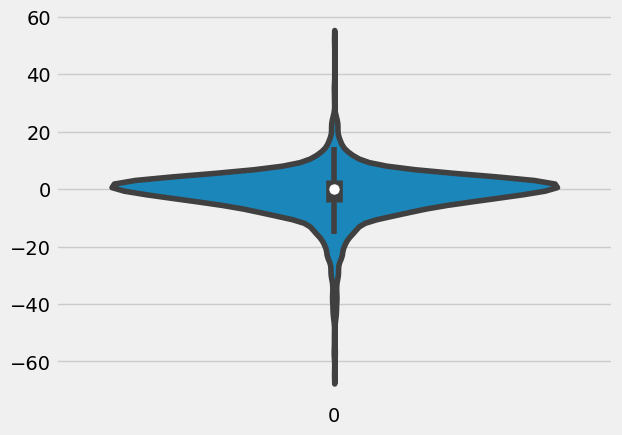

In [ ]:
sns.violinplot(result_df["Difference"])

Let's see how our predictions are close to the actual ones

Text(0.5, 1.0, '(RMSE = 8.41)')

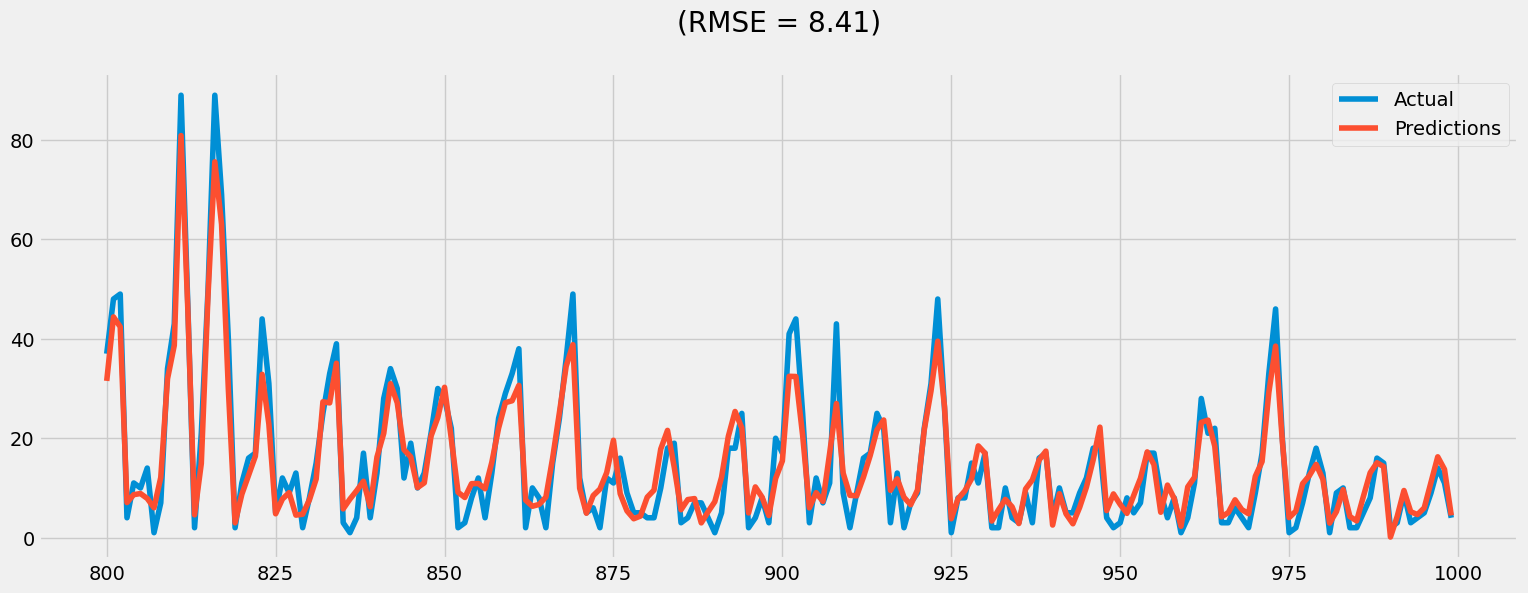

In [ ]:
result_df[['Actual', 'Predictions']][800:1000].plot(figsize=(17,6))
plt.title(f"(RMSE = {rmse})", pad="30.0")

## References

https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide

https://www.youtube.com/watch?v=kGdbPnMCdOg

https://www.kaggle.com/code/muhammetalientrk/implementation-of-apriori-algorithm-from-scratch

https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/

https://bobbyhadz.com/blog/python-add-hours-to-datetime#:~:text=Use%20the%20timedelta()%20class,of%20hours%20to%20the%20datetime.

numpy, pandas, matplotlib, seaborn, tensorflow documentations